<img src="Legends_of_Runeterra_Cover_01.jpg" alt="Drawing" style="width: 300px;"/>

<h1 align=center><font size = 5>Sentiment Analysis for Riot Games Legend of Runeterra</font></h1>
<h1 align=center><font size = 3><em>Munish Kumar</em></font></h1>

Legends of Runeterra (or LoR) is a card game developed by Riot Games. Set in the world of League of Legends, Legends of Runeterra is the strategy card game where choices made and risks taken determine winners or losers.

Riot games prides itself in being all about the player. This is, in fact, embodied in its mision statement, which is "Player Experience First". However, for a vision to be held to, there must be a report card of sorts. Forums like Reddit are thus well placed to provide feedback to companies like Riot Games as to how their game is being perceived by the community.

Although far from ideal, sentiment analysis is one way to "discretise" the opinions of LoR gamers. In this way, I don’t have to read through thousands of posts, trying to piece together what the players think. For me, there is another benefit to doing sentiment analysis and looking at forums like this. As a busy working adult, I do not want to invest time or effort in a game which players themselves feel is not worth engaging in. By looking at a basic metric of "positive" vs. "negative", I can very quickly tell if players think this game is a winner, or should be passed on for something else.

In order to do this, I will do the following analysis steps:
1. Scrape the most popular message board for player comments
2. Perform Sentiment Analysis using Python Natural Language Toolkit (NTLK)
3. Interpret the results and explain the observations

#### Import Libraries

In [1]:
from IPython import display
import os
import math
import time
from pprint import pprint #"pretty-print" JSON and lists
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

print("Libraries imported.")

Libraries imported.


In [2]:
# Start, test
start = time.time()

In [3]:
# Global Variables
dir_name = 'C:/Users/quant/Anaconda3/@Projects/Sentiment'
filename_suffix = 'csv'

The url below has the most number of comments and discussions regarding LoR. This is a megathread with over 2000 entries. 

In [4]:
url = 'https://www.reddit.com/r/LegendsOfRuneterra/comments/gqdwy2/patch_12_discussion_megathread/'

ID's for accessing the API

In [5]:
client_id=' '
client_secret=' '
user_agent=' '
username = ' '
password = ' '

#### Function to do Plotting

In [6]:
def plot_figures(df):
    ncols = 2
    fig, axes = plt.subplots(ncols=ncols)
    fig.set_figwidth(10)
    bins=21
    
    sns.distplot(df['compound'], hist = True,
                 bins=bins, ax=axes[0], color = 'r',
                hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':0.8})
    axes[0].set_title('Linear Bins')
    axes[0].set_xlim(-1.1,1.1)
    
    dfplot = df[df['compound'] !=0]
    
    sns.distplot(dfplot['compound'], hist = True,
                 bins=bins, ax=axes[1], color = 'orange',
                hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':0.8})
    axes[1].set_title('Linear Bins (minus 0)')
    axes[1].set_xlim(-1.1,1.1)
    return

#### Function to convert 'compound' scores after sentiment analysis from weighted average to -1 (negative setiment) or +1 (positive sentiment) for further quantification

In [7]:
def bool_sent(df, quant):
    df['Plus_Minus'] = 0
    
    for i in range(len(df['compound'])): 
        if df['compound'][i] > 1*quant:
            df['Plus_Minus'][i] = 1
        elif df['compound'][i] < -1*quant:
            df['Plus_Minus'][i] = -1
    return df

#### Function to do a Sentiment Count

In [8]:
def sentiment_count(df):
    print("Count of Sentiments:\n")
    print(df['Plus_Minus'].value_counts())
    print("\n")
    print("Count of Sentiments (%):\n")
    print(df['Plus_Minus'].value_counts(normalize = True)*100)
    return

#### Function to do a frequency of Most Common Word

In [9]:
def post_words(df, no_words, check_no):    
    plus_pos_tokens=[None]*df['Plus_Minus'].shape[0]
    ppos_tokens = []
    
    for i in range(df['Plus_Minus'].shape[0]):
        if df['Plus_Minus'][i] == check_no:
            plus_pos_tokens[i] = df['Measure'][i]
            
    for val in plus_pos_tokens:
        if val != None:
            ppos_tokens.append(val)
    
    pos_freq = nltk.FreqDist(ppos_tokens)
    return pos_freq.most_common(no_words)    

#### Checkpoint function

In [10]:
def checkpt(fname,df):
    # Write out the table as a csv as a checkpoint file
    base_filename = fname
    csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
    df.to_csv(csvs_sht, index = False, header=True)
    
    # A bit hackish, but I will read in the file I just produced, 
    # drop the duplicates and write out to the same file again
    df_check = pd.read_csv(csvs_sht)
    df_check.drop_duplicates(inplace = True)
    df_check.to_csv(csvs_sht, encoding='utf-8', index = False, header=True)
    print ("File " + base_filename + " Produced.") 
    return

In order to extract the data from Reddit, I need to firstly make a Reddit app. This is the steps I took:

1. Log into my account
2. Navigated to https://www.reddit.com/prefs/apps/
3. Clicked on the button that says "are you a developer? create an app..."
4. Entered a name (used my username)
5. Selected "script"
6. Used http://localhost:8080 as a redirect URI
7. Clicked "create app" to obtain Client ID and Client Secret

Note that this only has to be done once

In [11]:
import praw

reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent,
                     username = username,
                     password = password
                     )

Create a set to counter against duplicates

In [12]:
sentiments = set()

In [13]:
## Test
#subreddit = reddit.subreddit("LegendsOfRuneterra")
#
#for submission in subreddit.new(limit=None):
#    sentiments.add(submission.title)
#    display.clear_output()
#    print(len(sentiments))

#s = list(sentiments)
#print(np.array(s))
#df=pd.DataFrame(s)
#print(df)

In [14]:

sub = reddit.submission(url = url)

In [15]:
from praw.models import MoreComments

topics_dict = {"body":[]}

sub.comments.replace_more(limit=None)
for comment in sub.comments.list():
    # For testing
    #if isinstance(comment, MoreComments):
    #    continue
    #print(comment.body)
    sentiments.add(comment.body)
    topics_dict['body'].append(comment.body)

In [16]:
topics_data = pd.DataFrame(topics_dict)
print(topics_data.shape)
topics_data

(2425, 1)


,body
0,* **[Comment by RubinZoo](/r/LegendsOfRuneterr...
1,Freljord got buffed just indirectly. REALLY ha...
2,>The Bilgewater home screen background now app...
3,I think the Vlad change is bigger then it look...
4,that 1hp on rearguard is HUGE
...,...
2420,"On the contrary, I can take insults very well,..."
2421,"I don't hate midrange at all. In fact, I try t..."
2422,The value/benefit of US is still fine for a 8 ...
2423,"Well, you tried LMAO."


In [17]:
checkpt('Reddit_LoR_master_comments', topics_data)

File Reddit_LoR_master_comments Produced.


------------- 

For nltk to work, I need to use the vader lexicon. VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.

#### Lets do sentiment Analysis on the paragraphs

In [18]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\quant\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk import tokenize, RegexpTokenizer

sia = SIA()
results = []

for line in sentiments:
    pol_score = sia.polarity_scores(line)
    pol_score['Measure'] = line
    results.append(pol_score)

pprint(results[:3], width=200)

[{'Measure': 'I applaud their light handed, gradual approach to nerfs. Its laudable and the right way.\n'
             '\n'
             'The issue is that they really whiffed on a card that not only needs a nerf, but should never have passed QA.',
  'compound': 0.25,
  'neg': 0.0,
  'neu': 0.943,
  'pos': 0.057},
 {'Measure': 'We need a new emote tierlist hahaha', 'compound': 0.5574, 'neg': 0.0, 'neu': 0.581, 'pos': 0.419},
 {'Measure': 'It\'s known that there is a balance patch each month..\nLuckly for you, you are not "stuck" with that deck, continue playing and you will be able to craft a new deck in no time.',
  'compound': -0.1027,
  'neg': 0.063,
  'neu': 0.886,
  'pos': 0.051}]


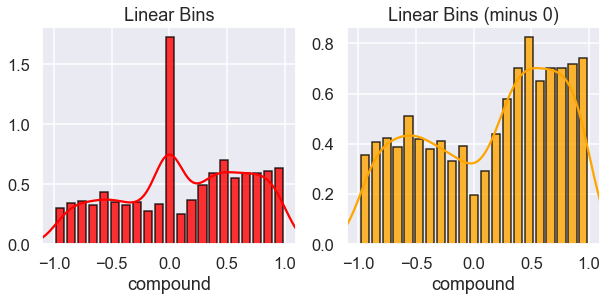

In [20]:
df = pd.DataFrame.from_records(results)
df.head()
plot_figures(df)

From the figure above, its essentially a trimodal distribution, but if you exclude the 0 (or neutral sentiments), then the bimodal distribution lends itself to spliting at +/- 0.3. A positive value will be given a +1 score and a negative value will be -1

In [21]:
df=bool_sent(df, 0.3)

C:\Users\quant\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\quant\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


What are examples of some of the positives and negative comments?

In [22]:
pprint("Positive Sentiments:")
pprint(list(df[df['Plus_Minus']==1]['Measure'])[25:27], width=200)

'Positive Sentiments:'
['Please try to climb with an undying kegs decklist.',
 'I don’t think Deep is overpowered, if you get Deep and manage to get Naut out you deserve to win (same as if you get to turn 10 with Karma and Ez on the board).']


In [23]:
pprint("Negative Sentiments:")
pprint(list(df[df['Plus_Minus']==-1]['Measure'])[25:27], width=200)

'Negative Sentiments:'
["I think the ultimate solution is the same as YuGiOh and it's spell speed system. Basically burst spells would be spell speed 3 meaning only other spell speed 3 things can match it and be played "
 'over it. Or at least make burst spells take up your entire turn like a fast spell would but have it in a way that means a fast spell cannot be played in response to it..  \n'
 '\n'
 '\n'
 "Or just remove it because it's shit and makes people feel bad.",
 'But he is a pirate that goes *yarr and yoink* towards his enemy']


In [24]:
sentiment_count(df)

Count of Sentiments:

 1    1012
 0     812
-1     579
Name: Plus_Minus, dtype: int64


Count of Sentiments (%):

 1    42.114024
 0    33.791094
-1    24.094881
Name: Plus_Minus, dtype: float64


Based on the sentiment analysis for the paragraph, overwhelmingly (by a factor 2:1), the sentiment is postive. However, the neutral headlines could be better characterized as it alone accounts for 1/3 of the data set results. This begs the question, do statistics improve dramatically, if I were to perform the sentiment analysis on sentences or individual words?

Create a checkpoint file by writing to csv

In [25]:
df2 = df[['Measure', 'Plus_Minus']]
checkpt('Reddit_LoR_labels_comment', df2)

File Reddit_LoR_labels_comment Produced.


------------- 

#### Lets do sentiment Analysis on the sentences

In [26]:
paragraph = str(sentiments)

This tokenizer segments the comments above into sentences

In [27]:
tokenizer = tokenize.sent_tokenize
sentence_list = tokenizer(paragraph)

In [28]:
results2 = []

for sentence in sentence_list:
    pol_score2 = sia.polarity_scores(sentence)
    pol_score2['Measure'] = sentence
    results2.append(pol_score2)

pprint(results2[:3], width=200)

[{'Measure': "{'I applaud their light handed, gradual approach to nerfs.", 'compound': 0.4588, 'neg': 0.0, 'neu': 0.727, 'pos': 0.273},
 {'Measure': 'Its laudable and the right way.\\n\\nThe issue is that they really whiffed on a card that not only needs a nerf, but should never have passed QA.',
  'compound': 0.0,
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'Measure': '\', \'We need a new emote tierlist hahaha\', \'It\\\'s known that there is a balance patch each month..\\nLuckly for you, you are not "stuck" with that deck, continue playing and you '
             'will be able to craft a new deck in no time.',
  'compound': -0.1027,
  'neg': 0.054,
  'neu': 0.902,
  'pos': 0.044}]


C:\Users\quant\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\quant\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Count of Sentiments:

 0    2317
 1    1756
-1    1152
Name: Plus_Minus, dtype: int64


Count of Sentiments (%):

 0    44.344498
 1    33.607656
-1    22.047847
Name: Plus_Minus, dtype: float64
File Reddit_LoR_labels_sentence Produced.


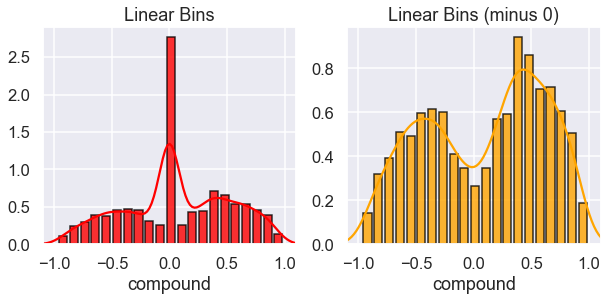

In [29]:
dfa = pd.DataFrame.from_records(results2)
dfa.head()
plot_figures(dfa) # Plot the Figures
dfa=bool_sent(dfa, 0.3) # Convert compound values to 1 or -1
sentiment_count(dfa)
df2a = dfa[['Measure', 'Plus_Minus']]
checkpt('Reddit_LoR_labels_sentence', df2a)

Based on the sentiment analysis for the individual sentences, 33% of commenters on the forum are positive towards LoR. 22% have expressed negative sentiments.

------------- 

#### Lets do sentiment Analysis on the words

Finally, lets remove the impact of punctuation to futher normalize the data.

In [30]:
tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')

Import Stopwords i.e. words that are irrelevant for text sentiment. 

In [31]:
from string import punctuation
# All possible punctuation in a string
print('From string.punctuation:', type(punctuation), punctuation)

From string.punctuation: <class 'str'> !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [32]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(type(stop_words))
stop_words_en_punc = str(stop_words).join(punctuation)
print(stop_words_en_punc[:10])

<class 'list'>
!['i', 'me


In [33]:
# Function to split every line into seperate words, removing the stop words
def process_text(lines):
    tokens = []
    for line in lines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words_en_punc]
        tokens.extend(toks)
    
    return tokens

In [34]:
paragraph_new = list(sentiments)
pos_tokens = process_text(paragraph_new)
pprint(pos_tokens[:10], width=200)

['applaud', 'light', 'handed', 'gradual', 'approach', 'nerfs', 'laudable', 'right', 'way', 'issue']


In [35]:
results3 = []

for token in pos_tokens:
    pol_score3 = sia.polarity_scores(token)
    pol_score3['Measure'] = token
    results3.append(pol_score3)

pprint(results3[:3], width=200)

[{'Measure': 'applaud', 'compound': 0.4588, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0},
 {'Measure': 'light', 'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'Measure': 'handed', 'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}]


C:\Users\quant\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\quant\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\quant\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Count of Sentiments:

 0    47974
 1     4899
-1     3117
Name: Plus_Minus, dtype: int64


Count of Sentiments (%):

 0    85.683158
 1     8.749777
-1     5.567066
Name: Plus_Minus, dtype: float64
File Reddit_LoR_labels_word Produced.


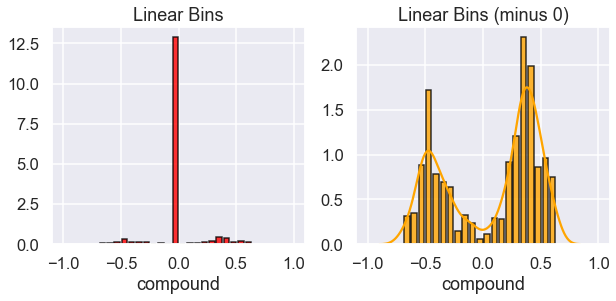

In [36]:
dfb = pd.DataFrame.from_records(results3)
dfb.head()
plot_figures(dfb) # Plot the Figures
dfb=bool_sent(dfb, 0.3) # Convert compound values to 1 or -1
sentiment_count(dfb) # Count of the Sentiments
df2b = dfb[['Measure', 'Plus_Minus']]
checkpt('Reddit_LoR_labels_word', df2b)

We do not learn anything new from the sentiment analysis done on the sentences. Overall, from a single word point of view, only 8% of the language used is constructive. 5% is (in this exercise) criticism of negative.

In my opinion, single word sentiment analysis does not do well, with far too many neutral words. Still, I can analyse the positive and negative individual words as a frequency distribution as well as a word cloud. The frequency distribution will tell me how many times the word appears across the forum. The word cloud is just a iconographic representation of that.

In [37]:
dfb.head()

,neg,neu,pos,compound,Measure,Plus_Minus
0,0.0,0.0,1.0,0.4588,applaud,1
1,0.0,1.0,0.0,0.0000,light,0
2,0.0,1.0,0.0,0.0000,handed,0
3,0.0,1.0,0.0,0.0000,gradual,0
4,0.0,1.0,0.0,0.0000,approach,0


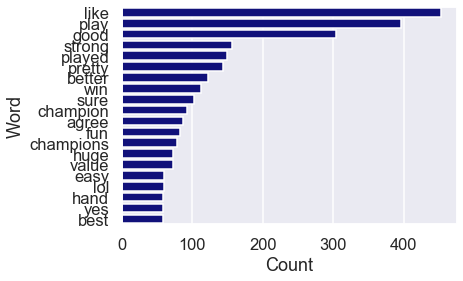

In [38]:
pwords = post_words(dfb, 20, 1)
df_pwords = pd.DataFrame(pwords, columns=['Word', 'Count'])
df_pwords
sns.barplot(x="Count", y="Word", data=df_pwords,
            label="Positve Words", color="darkblue", )

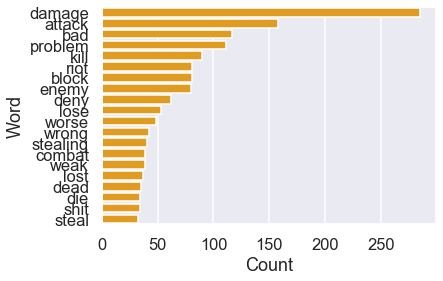

In [39]:
nwords = post_words(dfb, 20, -1)
df_nwords = pd.DataFrame(nwords, columns=['Word', 'Count'])
df_pwords
sns.barplot(x="Count", y="Word", data=df_nwords,
            label="Positve Words", color="orange")

In [40]:
checkpt('Reddit_LoR_labels_pos_words', df_pwords)
checkpt('Reddit_LoR_labels_neg_words', df_nwords)

File Reddit_LoR_labels_pos_words Produced.
File Reddit_LoR_labels_neg_words Produced.


#### Create word clouds

The word cloud here is a stylized representation of the bar plot above

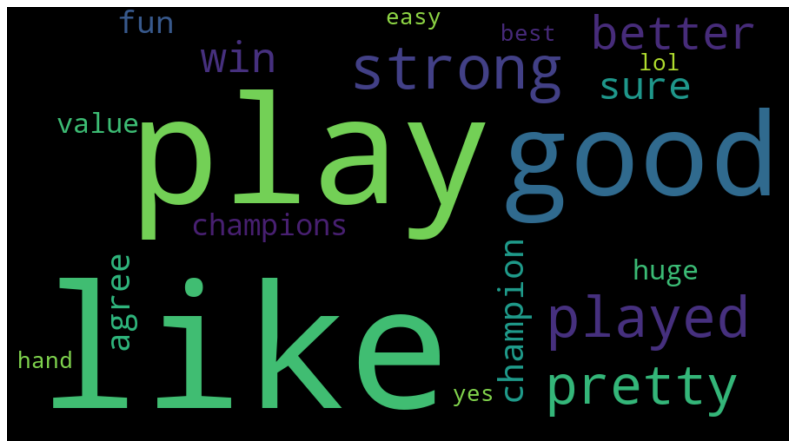

In [41]:
from wordcloud import WordCloud, STOPWORDS
import csv

file = open('Reddit_LoR_labels_pos_words.csv', 'r',newline='\n')
reader = csv.reader(file)
next(reader)
d = {}
for k,v in reader:
    d[k] = int(v)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
    
# Generating wordcloud. 
# Relative scaling value is to adjust the 
# importance of a frequency word.
wordcloud = WordCloud(
    width=900, 
    height=500, 
    max_words=1628, 
    relative_scaling=1, 
    normalize_plurals=False).generate_from_frequencies(d)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

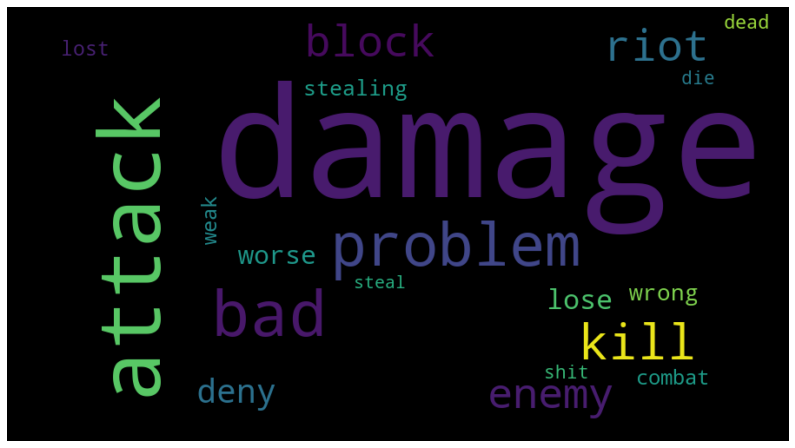

In [42]:
from wordcloud import WordCloud, STOPWORDS
import csv

file = open('Reddit_LoR_labels_neg_words.csv', 'r',newline='\n')
reader = csv.reader(file)
next(reader)
d = {}
for k,v in reader:
    d[k] = int(v)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
    
# Generating wordcloud. 
# Relative scaling value is to adjust the 
# importance of a frequency word.
wordcloud = WordCloud(
    width=900, 
    height=500, 
    max_words=1628, 
    relative_scaling=1, 
    normalize_plurals=False).generate_from_frequencies(d)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [43]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 169.09813976287842 seconds


### Conclusion

Here are a few conlcusions from the sentiment analysis performed on the megathread at Reddit

1. Positive Sentiment via "Paragraph" sentiment analyis was 42%, while Negative Sentiment was 24%.
2. Positive Sentiment via "Sentence" sentiment analyis was 33%, while Negative Sentiment was 22%.
3. Positive Sentiment via "Word" sentiment analyis was 8%, while Negative Sentiment was 5%.
4. We see (in general, for this forum) a POSITIVE sentiment towards LoR, with words "like", "play" and "good" scoring highly. However, note that the context in which these words appear is not analyzed.
5. Positive sentiment in (1) and (2) differ by only 10%, while negative sentiment is very similar, at only 2% difference. If this is converted to a margin of error (MoE), then this can be translated that a ~10% variation in the results can be expected depending on the results attempted. MoE here must now be calibrated against other forums to see if this is a true indication of the data.
6. It is also no surprise that words like 'attacked' or 'damaged' showed up often; it can be postulated that in a game such as this, that any sort of action to the detriment of the player will de discussed heavily and negatively.

So, based on the above LoR looks like its worth trying out....now to convince the wife......
